In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import keras.backend as K

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

Gradcam for one layer before the one used previously.

In [ ]:
model = VGG16(weights="imagenet")
from skimage import io
sunglasses = io.imread("https://ae01.alicdn.com/kf/HTB1wnD8bcrrK1RjSspaq6AREXXaR/MK100-Tony-Stark-Doll-Head-Carved-Glasses-Seamless-Flexible-Body-1-6-Action-Figure-Scale-Model.jpg_q50.jpg")

sunglasses = cv2.resize(sunglasses, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(sunglasses)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
class_idx = np.argmax(preds)
print(class_idx)
class_output = model.output[:, 837]
last_conv_layer = model.get_layer("block5_conv3")

145


In [ ]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


In [ ]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


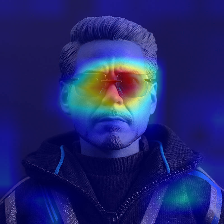

In [ ]:
heatmap = cv2.resize(heatmap, (sunglasses.shape[1], sunglasses.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(sunglasses, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)